In [1]:
! pip install kaggle
! mkdir ~/.kaggle
! cp kaggle.json ~/.kaggle/
! chmod 600 ~/.kaggle/kaggle.json

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
! kaggle datasets download grassknoted/asl-alphabet
!unzip -q asl-alphabet.zip 

100% 1.02G/1.03G [00:31<00:00, 42.7MB/s]
100% 1.03G/1.03G [00:31<00:00, 34.9MB/s]


In [3]:
from torchvision import models, transforms, datasets
import torch
from torch import nn
import matplotlib.pyplot as plt
from time import time
from tqdm import tqdm
from torch.nn.parallel import DistributedDataParallel as DDP
import warnings
warnings.simplefilter("ignore")

## Plotting a few images to understand the dataset

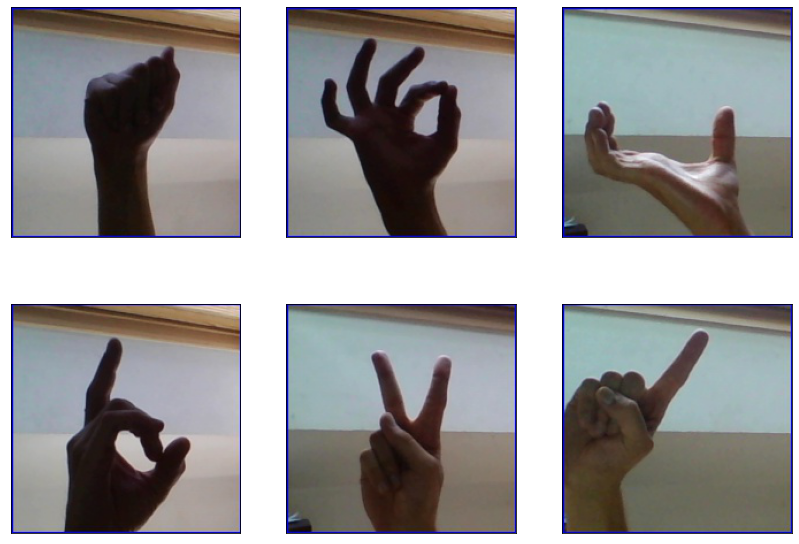

In [7]:
path1='asl_alphabet_train/asl_alphabet_train/A/A10.jpg'
path2='asl_alphabet_train/asl_alphabet_train/F/F10.jpg'
path3='asl_alphabet_train/asl_alphabet_train/space/space10.jpg'
path4='asl_alphabet_train/asl_alphabet_train/D/D10.jpg'
path5='asl_alphabet_train/asl_alphabet_train/K/K10.jpg'
path6='asl_alphabet_train/asl_alphabet_train/Z/Z10.jpg'
paths=[path1,path2,path3,path4,path5,path6]
plt.figure(figsize=(14, 10))
i=1
for path in paths:
  
    plt.subplot(2, 3, i)
    i+=1
    plt.imshow(plt.imread(path)) 
    plt.xticks([])
    plt.yticks([])
    
plt.show()

In [8]:
def transform_split_dataset(resize_shape,path,samples):

  #transforming the dataset i.e. resizing and recenntering it
  torch.manual_seed(45)
  const_mean=[0.485, 0.456, 0.406]
  const_std=[0.229, 0.224, 0.225]
  transformations = transforms.Compose([transforms.Resize(resize_shape),transforms.ToTensor(),
      transforms.Normalize(mean=const_mean,std=const_std)])

  train_dataset = datasets.ImageFolder(path, transform=transformations)
  test_dataset = datasets.ImageFolder(path, transform=transformations)

  #performing random train test split
  test_split = 0.2
  pivot = int(samples * test_split)
  indices = torch.randperm(samples)

  train_subset = torch.utils.data.Subset(train_dataset, indices[pivot:])
  test_subset = torch.utils.data.Subset(test_dataset, indices[:pivot])

  print('Total images in train dataset',len(train_subset))
  print('Total images in test dataset',len(test_subset))

  return train_subset,test_subset

In [9]:
def model_loader(batch_size,train_subset,val_subset,model,name):
  batch_size = batch_size

  train_dataloader = torch.utils.data.DataLoader(
      dataset=train_subset, 
      batch_size=batch_size,
      shuffle=True,num_workers=4)

  val_dataloader = torch.utils.data.DataLoader(
      dataset=val_subset,
      batch_size=batch_size,
      shuffle=False,num_workers=4)
  classes = 29
  train_model = nn.DataParallel(model)
  for param in train_model.parameters():
    param.requires_grad = False
  #the final layer of models used is different for some models
  if name=='resnet' or name=='googlenet':
      fc = nn.Linear(in_features=train_model.module.fc.in_features, out_features=classes)
      train_model.module.fc = fc
  else:
     in_features = train_model.module.classifier[-1].in_features
     train_model.module.classifier[-1] = nn.Linear(in_features, classes)
  #defining which parameter to update
  updated_parameters = []
  for name, grad in train_model.named_parameters():
    if grad.requires_grad == True:
        updated_parameters.append(grad)

  #defining the loss function and optimizer      
  loss_function = nn.CrossEntropyLoss()
  optimizer = torch.optim.Adam(updated_parameters, lr=0.0003) 
  return train_model,loss_function,optimizer,train_dataloader,val_dataloader

In [10]:
def evaluation_accuracy(dataloader,model,device):
    total_datapoints, true_positives = 0, 0
    for data in dataloader:
        inputs, labels = data
        inputs=inputs.to(device)
        labels=labels.to(device)
        outputs = model(inputs)
        val, pred = torch.max(outputs.data, 1)
        total_datapoints += labels.size(0)
        true_positives += (pred == labels).sum().item()
    return (true_positives / total_datapoints)*100

In [13]:
def train(model,criterion,optimizer,train_dataloader,test_dataloader,print_every,num_epoch,device):
    train_accuracy_list,val_accuracy_list=[], []
    model.to(device)
    start=time()
    for epoch in (range(num_epoch)):
        model.train()
        start_epoch=time()
        for i, (images, labels) in enumerate(train_dataloader):
            images = images.to(device)
            labels = labels.to(device)

            output = model(images)
            loss = criterion(output, labels)
            loss_value=loss
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        train_accuracy= evaluation_accuracy(train_dataloader,model,device) 
        test_accuracy= evaluation_accuracy(test_dataloader,model,device)
        #train_losses.append(loss_value)
        print('Epoch: {}/{} Loss: {} Test acc: {} Train acc: {} Time : {} seconds'.format(epoch+1, num_epoch, loss_value,round(test_accuracy,4),round(train_accuracy,4), round(time()-start_epoch,4)))
        train_accuracy_list.append(train_accuracy)
        val_accuracy_list.append(test_accuracy)
        
        
    return model,train_accuracy_list,val_accuracy_list


In [14]:
if __name__=='__main__':
  all_models_train_accuracy={}
  all_models_test_accuracy={}
  all_models_time={}
  train_data_path='asl_alphabet_train/asl_alphabet_train'
  train_subset,val_subset=transform_split_dataset(64,train_data_path,10000)
  models_list = ['resnet','alexnet','vgg19','googlenet']
  for model_name in models_list:
    print('Training data with -',model_name)
    
    if model_name=='resnet':
        model=models.resnet50(pretrained=True)
    elif model_name=='alexnet':
        model=models.alexnet(pretrained=True)
    elif model_name=='googlenet':
        model=models.googlenet(pretrained=True)
    else:
        model=models.vgg19(pretrained=True)
    
    
    train_model,criterion,optimizer,train_dataloader,val_dataloader=model_loader(32,train_subset,val_subset,model,model_name)
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    start=time()
    final_model,train_accuracy,val_accuracy=train(train_model,criterion,optimizer,train_dataloader,val_dataloader,150,5,device)
    all_models_train_accuracy[model_name]=train_accuracy
    all_models_test_accuracy[model_name]=val_accuracy
    
    end=time()
    print('On Device',device)
    print('Time taken - ',str(end-start)+' seconds')
    all_models_time[model_name]=end-start
    print('*'*50)

Total images in train dataset 8000
Total images in test dataset 2000
Training data with - resnet
Epoch: 1/5 Loss: 0.38667264580726624 Test acc: 89.75 Train acc: 89.5875 Time : 27.8932 seconds
Epoch: 2/5 Loss: 0.2845400273799896 Test acc: 92.65 Train acc: 92.7 Time : 25.1893 seconds
Epoch: 3/5 Loss: 0.35004839301109314 Test acc: 92.95 Train acc: 93.8125 Time : 25.4511 seconds
Epoch: 4/5 Loss: 0.23390384018421173 Test acc: 93.45 Train acc: 94.0625 Time : 25.6864 seconds
Epoch: 5/5 Loss: 0.1151469498872757 Test acc: 94.05 Train acc: 94.7 Time : 25.5975 seconds
On Device cuda
Time taken -  129.82435607910156 seconds
**************************************************
Training data with - alexnet


Downloading: "https://download.pytorch.org/models/alexnet-owt-7be5be79.pth" to /root/.cache/torch/hub/checkpoints/alexnet-owt-7be5be79.pth


  0%|          | 0.00/233M [00:00<?, ?B/s]

Epoch: 1/5 Loss: 0.07779912650585175 Test acc: 95.45 Train acc: 96.5125 Time : 21.5472 seconds
Epoch: 2/5 Loss: 0.1459117829799652 Test acc: 96.7 Train acc: 97.8125 Time : 22.1727 seconds
Epoch: 3/5 Loss: 0.09687267988920212 Test acc: 97.7 Train acc: 98.15 Time : 24.6665 seconds
Epoch: 4/5 Loss: 0.16265663504600525 Test acc: 98.6 Train acc: 98.525 Time : 21.6679 seconds
Epoch: 5/5 Loss: 0.0636960044503212 Test acc: 98.45 Train acc: 98.6 Time : 21.575 seconds
On Device cuda
Time taken -  111.63363456726074 seconds
**************************************************
Training data with - vgg19


Downloading: "https://download.pytorch.org/models/vgg19-dcbb9e9d.pth" to /root/.cache/torch/hub/checkpoints/vgg19-dcbb9e9d.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

Epoch: 1/5 Loss: 0.18549619615077972 Test acc: 92.05 Train acc: 92.3125 Time : 22.8611 seconds
Epoch: 2/5 Loss: 0.1189311221241951 Test acc: 94.15 Train acc: 94.7375 Time : 22.9102 seconds
Epoch: 3/5 Loss: 0.08571009337902069 Test acc: 95.8 Train acc: 95.975 Time : 22.9606 seconds
Epoch: 4/5 Loss: 0.127959206700325 Test acc: 95.45 Train acc: 95.975 Time : 22.7888 seconds
Epoch: 5/5 Loss: 0.07220850139856339 Test acc: 95.6 Train acc: 96.55 Time : 22.9604 seconds
On Device cuda
Time taken -  114.48609328269958 seconds
**************************************************
Training data with - googlenet


Downloading: "https://download.pytorch.org/models/googlenet-1378be20.pth" to /root/.cache/torch/hub/checkpoints/googlenet-1378be20.pth


  0%|          | 0.00/49.7M [00:00<?, ?B/s]

Epoch: 1/5 Loss: 0.5027446150779724 Test acc: 85.9 Train acc: 86.3375 Time : 25.9657 seconds
Epoch: 2/5 Loss: 0.3356117010116577 Test acc: 88.65 Train acc: 89.525 Time : 25.6976 seconds
Epoch: 3/5 Loss: 0.5068559646606445 Test acc: 91.1 Train acc: 91.9375 Time : 25.6142 seconds
Epoch: 4/5 Loss: 0.19639290869235992 Test acc: 91.35 Train acc: 92.8125 Time : 26.0239 seconds
Epoch: 5/5 Loss: 0.2903002202510834 Test acc: 92.85 Train acc: 92.525 Time : 25.7368 seconds
On Device cuda
Time taken -  129.04970049858093 seconds
**************************************************


##Plotting the performance of different models

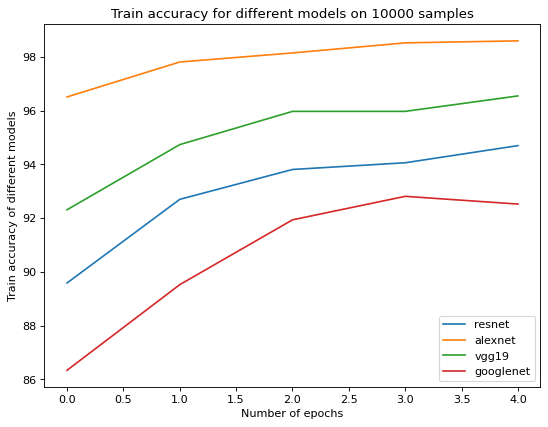

In [18]:
import numpy as np
import matplotlib.pyplot as plt
epochs=np.arange(5)
plt.figure(figsize=(8, 6), dpi=80)
plt.title('Train accuracy for different models on 10000 samples')
plt.xlabel('Number of epochs')
plt.ylabel('Train accuracy of different models')

plt.plot(epochs,all_models_train_accuracy['resnet'],label='resnet')
plt.plot(epochs,all_models_train_accuracy['alexnet'],label='alexnet')
plt.plot(epochs,all_models_train_accuracy['vgg19'],label='vgg19')
plt.plot(epochs,all_models_train_accuracy['googlenet'],label='googlenet')
plt.legend()
plt.show()

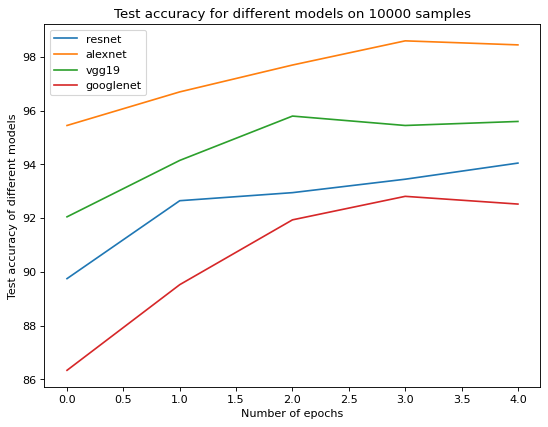

In [19]:
plt.figure(figsize=(8, 6), dpi=80)
plt.title('Test accuracy for different models on 10000 samples')
plt.xlabel('Number of epochs')
plt.ylabel('Test accuracy of different models')

plt.plot(epochs,all_models_test_accuracy['resnet'],label='resnet')
plt.plot(epochs,all_models_test_accuracy['alexnet'],label='alexnet')
plt.plot(epochs,all_models_test_accuracy['vgg19'],label='vgg19')
plt.plot(epochs,all_models_train_accuracy['googlenet'],label='googlenet')
plt.legend()
plt.show()

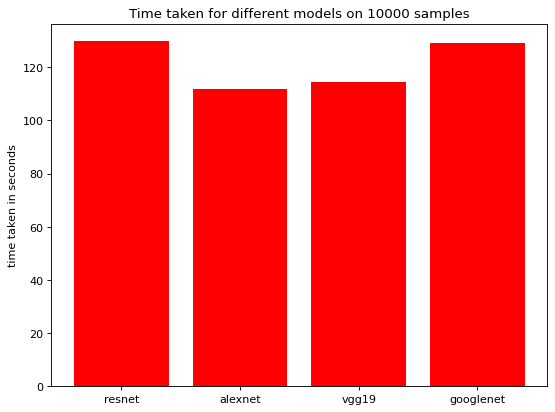

In [20]:
plt.figure(figsize=(8, 6), dpi=80)
plt.title('Time taken for different models on 10000 samples')
plt.ylabel('time taken in seconds')
plt.bar(all_models_time.keys(),all_models_time.values(),color='red')
plt.show()